# Training and Testing strategy design
This problem is peculiar when it comes to training and especially testing the ML models.

First of all, it's time-based data, with all the consideration that comes from that, including trying to avoid label leakage, and taking care of causality for example when splitting the data, and so on.

Secondly, and more importantly, the testing data doesn't have the features that we used to train the model, only the customer_ids. This could have lead us to a solution where we build prediction models/forecasts per customer, but given:
1. That the majority of the customers (~60%) in the data are one-time orderers. (will lead to sparsity)
2. The lack of data about the customers themselves, but only about the orders.

I decided to take the approach of prediction per order.

In that case, the testing data will have to look like the training data, i.e. it will have to look like orders. Because that's how the model works, it takes an order, and gives the prediction whether there is going to be another order in 6 months from that same customer.

That is why, I decided to enrich the testing data with the details of the **last order** of that particular customer.

Ideally, to avoid leakage in general, I would have removed the entries that would be used to enrich testing from the training data to avoid leakage, but given that in the test data has ALL the customers in the training data, that means that we will remove all the one-time orderers, which is the majority of the data, so I decided not to do that at least in the first version of the model.

There are 2 customers that are in the testing data, but not in the training data, so I will drop them for now, but a future model can just give the median value, or another definition of a default value.

Now as explained in the **Target Variable Definition** I said I will try 2 approaches, classification and regression, here's how each would work:

Classification approach:
1. Train model
2. Enrich Testing data
3. Predict the labels for the Testing data
4. Evaluate classification scores.

Regression approach:
1. Train model
2. Enrich Testing data
3. Predict the time-to-next-orders for the Testing data (in hours)
4. Add the predicted hours to the order_time to get the predicted_order_time
5. The 'is_returning_customer' boolean variable that is going to be calculated as whether the predicted_order_time is before or after '2017-08-28' (which is 6 months after '2017-02-28').
6. Evaluate classification scores.


In this notebook I will try both approaches and show results.

I decided to use XGBoost algorithm for both approaches because of its robustness to outliers and NaNs and unstandardised ranges of features, and also because we do have lots of features to sample from.


# Config

In [1]:
VALIDATION_DATA_SIZE = 0.2 #As a fraction of the training data
SPLIT_DATA = 'normal' #As opposed to 'chronological'
INF_TIME_TO_NEXT_ORDER = 20000 #This will replace NaNs in time-to-next-order for the last orders

#Constants
random_seed = 42

# Imports

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("..") #There are better ways to do this
from calculation_functions.HelperFunctions import my_train_valid_split

from xgboost import XGBClassifier, XGBRegressor, plot_importance

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix


pd.set_option('display.max_columns', None)

# Reading Data

In [3]:
#The engineered data
Data = pd.read_csv("Engineered_Data.csv")

#The features are everything in the Data except for:
#['customer_id', 'order_time', 'time_to_next_order', 'is_returning_customer']
# The first two are there for merging purposes with Testing data, and the last two are target variables.

Feature_Columns = list(Data.drop(['customer_id', 'order_time',
                                  'time_to_next_order', 'is_returning_customer'],axis=1).columns)
Data

,customer_id,is_failed,voucher_amount,delivery_fee,amount_paid,order_time,time_since_last_order,customer_order_rank,time_to_next_order,is_returning_customer,year,hour_sin,hour_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,0,0.0,0.000,11.46960,2015-06-20 19:00:00,NaN,1,NaN,0,2015,-0.965926,0.258819,-0.743145,-0.669131,-0.974928,-0.222521,0.500000,-8.660254e-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0000e2c6d9be,0,0.0,0.000,9.55800,2016-01-29 20:00:00,NaN,1,NaN,0,2016,-0.866025,0.500000,-0.406737,0.913545,-0.433884,-0.900969,0.000000,1.000000e+00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,000133bb597f,0,0.0,0.493,5.93658,2017-02-26 19:00:00,NaN,1,NaN,0,2017,-0.965926,0.258819,-0.866025,0.500000,-0.781831,0.623490,0.500000,8.660254e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,00018269939b,0,0.0,0.493,9.82350,2017-02-05 17:00:00,NaN,1,NaN,0,2017,-0.965926,-0.258819,0.743145,0.669131,-0.781831,0.623490,0.500000,8.660254e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0001a00468a6,0,0.0,0.493,5.15070,2015-08-04 19:00:00,NaN,1,NaN,0,2015,-0.965926,0.258819,0.587785,0.809017,0.781831,0.623490,-0.500000,-8.660254e-01,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785996,fffe9d5a8d41,1,0.0,0.000,10.72620,2016-09-30 20:00:00,0.0,3,NaN,0,2016,-0.866025,0.500000,-0.207912,0.978148,-0.433884,-0.900969,-0.866025,-5.000000e-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
785997,ffff347c3cfa,0,0.0,0.000,7.59330,2016-08-17 21:00:00,NaN,1,696.0,1,2016,-0.707107,0.707107,-0.207912,-0.978148,0.974928,-0.222521,-0.500000,-8.660254e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
785998,ffff347c3cfa,0,0.0,0.000,5.94720,2016-09-15 21:00:00,696.0,2,NaN,0,2016,-0.707107,0.707107,0.207912,-0.978148,0.433884,-0.900969,-0.866025,-5.000000e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
785999,ffff4519b52d,0,0.0,0.000,21.77100,2016-04-02 19:00:00,NaN,1,NaN,0,2016,-0.965926,0.258819,0.207912,0.978148,-0.974928,-0.222521,1.000000,6.123234e-17,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [4]:
#The testing data
Testing_Data = pd.read_csv("../data/machine_learning_challenge_labeled_data.csv.gz")
Testing_Data

,customer_id,is_returning_customer
0,000097eabfd9,0
1,0000e2c6d9be,0
2,000133bb597f,1
3,00018269939b,0
4,0001a00468a6,0
...,...,...
245450,fffd696eaedd,0
245451,fffe9d5a8d41,1
245452,ffff347c3cfa,1
245453,ffff4519b52d,0


### Enriching the Testing data

In [5]:
#Getting the last order per customer
Last_orders_per_customer = Data.drop_duplicates(subset='customer_id', keep = 'last')

#Merging with the Testing data
Testing_Data = pd.merge(Testing_Data, Last_orders_per_customer[Feature_Columns + ['order_time', 'customer_id']], on='customer_id')
Testing_Data

,customer_id,is_returning_customer,is_failed,voucher_amount,delivery_fee,amount_paid,time_since_last_order,customer_order_rank,year,hour_sin,hour_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124,order_time
0,000097eabfd9,0,0,0.0,0.0000,11.46960,NaN,1,2015,-9.659258e-01,0.258819,-0.743145,-0.669131,-0.974928,-0.222521,0.500000,-8.660254e-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2015-06-20 19:00:00
1,0000e2c6d9be,0,0,0.0,0.0000,9.55800,NaN,1,2016,-8.660254e-01,0.500000,-0.406737,0.913545,-0.433884,-0.900969,0.000000,1.000000e+00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2016-01-29 20:00:00
2,000133bb597f,1,0,0.0,0.4930,5.93658,NaN,1,2017,-9.659258e-01,0.258819,-0.866025,0.500000,-0.781831,0.623490,0.500000,8.660254e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2017-02-26 19:00:00
3,00018269939b,0,0,0.0,0.4930,9.82350,NaN,1,2017,-9.659258e-01,-0.258819,0.743145,0.669131,-0.781831,0.623490,0.500000,8.660254e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2017-02-05 17:00:00
4,0001a00468a6,0,0,0.0,0.4930,5.15070,NaN,1,2015,-9.659258e-01,0.258819,0.587785,0.809017,0.781831,0.623490,-0.500000,-8.660254e-01,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2015-08-04 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245448,fffd696eaedd,0,0,0.0,1.4297,24.13395,NaN,1,2015,1.224647e-16,-1.000000,0.406737,-0.913545,0.000000,1.000000,-0.866025,-5.000000e-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2015-09-14 12:00:00
245449,fffe9d5a8d41,1,1,0.0,0.0000,10.72620,0.0,3,2016,-8.660254e-01,0.500000,-0.207912,0.978148,-0.433884,-0.900969,-0.866025,-5.000000e-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2016-09-30 20:00:00
245450,ffff347c3cfa,1,0,0.0,0.0000,5.94720,696.0,2,2016,-7.071068e-01,0.707107,0.207912,-0.978148,0.433884,-0.900969,-0.866025,-5.000000e-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2016-09-15 21:00:00
245451,ffff4519b52d,0,0,0.0,0.0000,21.77100,NaN,1,2016,-9.659258e-01,0.258819,0.207912,0.978148,-0.974928,-0.222521,1.000000,6.123234e-17,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2016-04-02 19:00:00


# Regression Approach

## Splitting the data for validation
Normally, with time-based data the split should always be chronological. But in that case, time information has been captured in the time features. So it could be ok to split without chronological order.
I combined both split techniques (normal, and chronlogical) into a function with a setting to choose the split technique.

In [22]:
TARGET_COL = 'time_to_next_order'
X_train, X_valid, y_train, y_valid = my_train_valid_split(Data= Data[Feature_Columns+[TARGET_COL,'order_time']],
                                                          target_col= TARGET_COL,
                                                          random_seed= random_seed,
                                                          validation_data_size= VALIDATION_DATA_SIZE,
                                                          split_data= SPLIT_DATA)

y_train = y_train.fillna(INF_TIME_TO_NEXT_ORDER)
y_valid = y_valid.fillna(INF_TIME_TO_NEXT_ORDER)

## Training

In [10]:
model_r = XGBRegressor(random_state= random_seed)
model_r.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=True, early_stopping_rounds = 20)

[0]	validation_0-rmse:9499.52344	validation_1-rmse:9496.10156
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:8474.77246	validation_1-rmse:8473.45410
[2]	validation_0-rmse:7916.37158	validation_1-rmse:7916.45068
[3]	validation_0-rmse:7620.38721	validation_1-rmse:7620.91846
[4]	validation_0-rmse:7467.65283	validation_1-rmse:7469.54199
[5]	validation_0-rmse:7385.93359	validation_1-rmse:7389.27490
[6]	validation_0-rmse:7342.31348	validation_1-rmse:7346.43799
[7]	validation_0-rmse:7316.09717	validation_1-rmse:7321.61377
[8]	validation_0-rmse:7301.23926	validation_1-rmse:7308.15186
[9]	validation_0-rmse:7292.91113	validation_1-rmse:7301.29932
[10]	validation_0-rmse:7285.28564	validation_1-rmse:7295.21631
[11]	validation_0-rmse:7279.96728	validation_1-rmse:7291.58643
[12]	validation_0-rmse:7276.77051	validation_1-rmse:7290.20508
[13]	validation_0-rmse:7273.4438

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation
### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

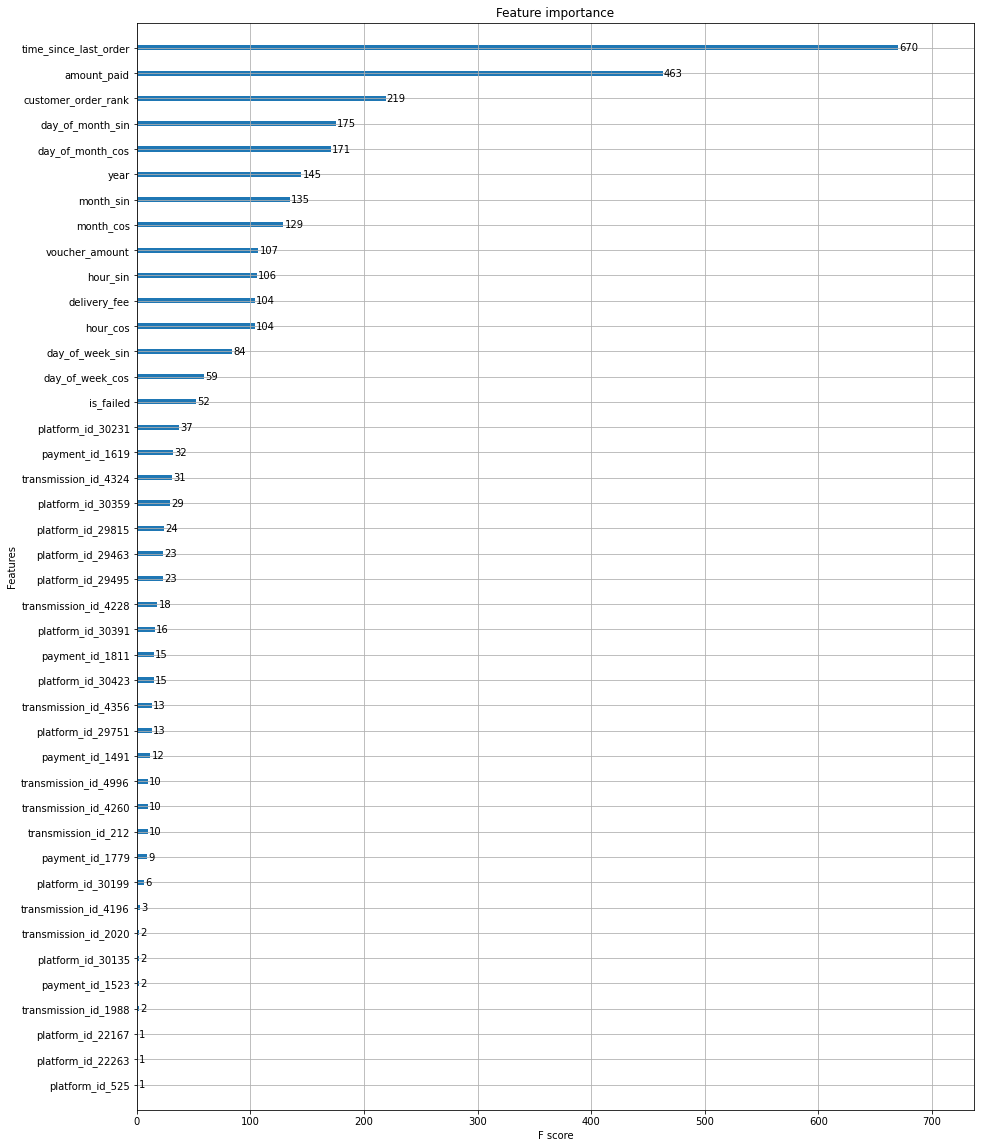

In [11]:
plt.rcParams["figure.figsize"] = (15, 20)
plot_importance(model_r)

### Classification Score

In [16]:
Testing_Data['predicted_time_to_next_order'] = model_r.predict(Testing_Data[Feature_Columns])
Testing_Data['predicted_order_time'] = pd.to_datetime(Testing_Data.order_time) + pd.to_timedelta(Testing_Data.predicted_time_to_next_order, unit='h')
y_pred = Testing_Data.predicted_order_time<='2017-08-28'


# Confusion Matrix and Classification report
print(confusion_matrix(Testing_Data['is_returning_customer'], y_pred))
print(classification_report(Testing_Data['is_returning_customer'], y_pred))

[[ 89208 100740]
 [ 37755  17750]]
              precision    recall  f1-score   support

           0       0.70      0.47      0.56    189948
           1       0.15      0.32      0.20     55505

    accuracy                           0.44    245453
   macro avg       0.43      0.39      0.38    245453
weighted avg       0.58      0.44      0.48    245453



# Classification Approach

## Splitting the data for validation
Now we can stratify our data.

In [26]:
TARGET_COL = 'is_returning_customer'
X_train, X_valid, y_train, y_valid = my_train_valid_split(Data= Data[Feature_Columns+[TARGET_COL,'order_time']],
                                                          target_col= TARGET_COL,
                                                          random_seed= random_seed,
                                                          validation_data_size= VALIDATION_DATA_SIZE,
                                                          split_data= SPLIT_DATA,
                                                          stratify=True)

## Training

In [27]:
model_c = XGBClassifier(random_state= random_seed)
model_c.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          verbose=True, early_stopping_rounds = 20)

[0]	validation_0-error:0.23064	validation_1-error:0.23185
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.23020	validation_1-error:0.23161
[2]	validation_0-error:0.23017	validation_1-error:0.23139
[3]	validation_0-error:0.22937	validation_1-error:0.23118
[4]	validation_0-error:0.22894	validation_1-error:0.23087
[5]	validation_0-error:0.22884	validation_1-error:0.23055
[6]	validation_0-error:0.22864	validation_1-error:0.23058
[7]	validation_0-error:0.22858	validation_1-error:0.23043
[8]	validation_0-error:0.22838	validation_1-error:0.23007
[9]	validation_0-error:0.22827	validation_1-error:0.23001
[10]	validation_0-error:0.22809	validation_1-error:0.22995
[11]	validation_0-error:0.22810	validation_1-error:0.22997
[12]	validation_0-error:0.22800	validation_1-error:0.23006
[13]	validation_0-error:0.22783	validation_1-error:0.23010
[14]	validation_0-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation
### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

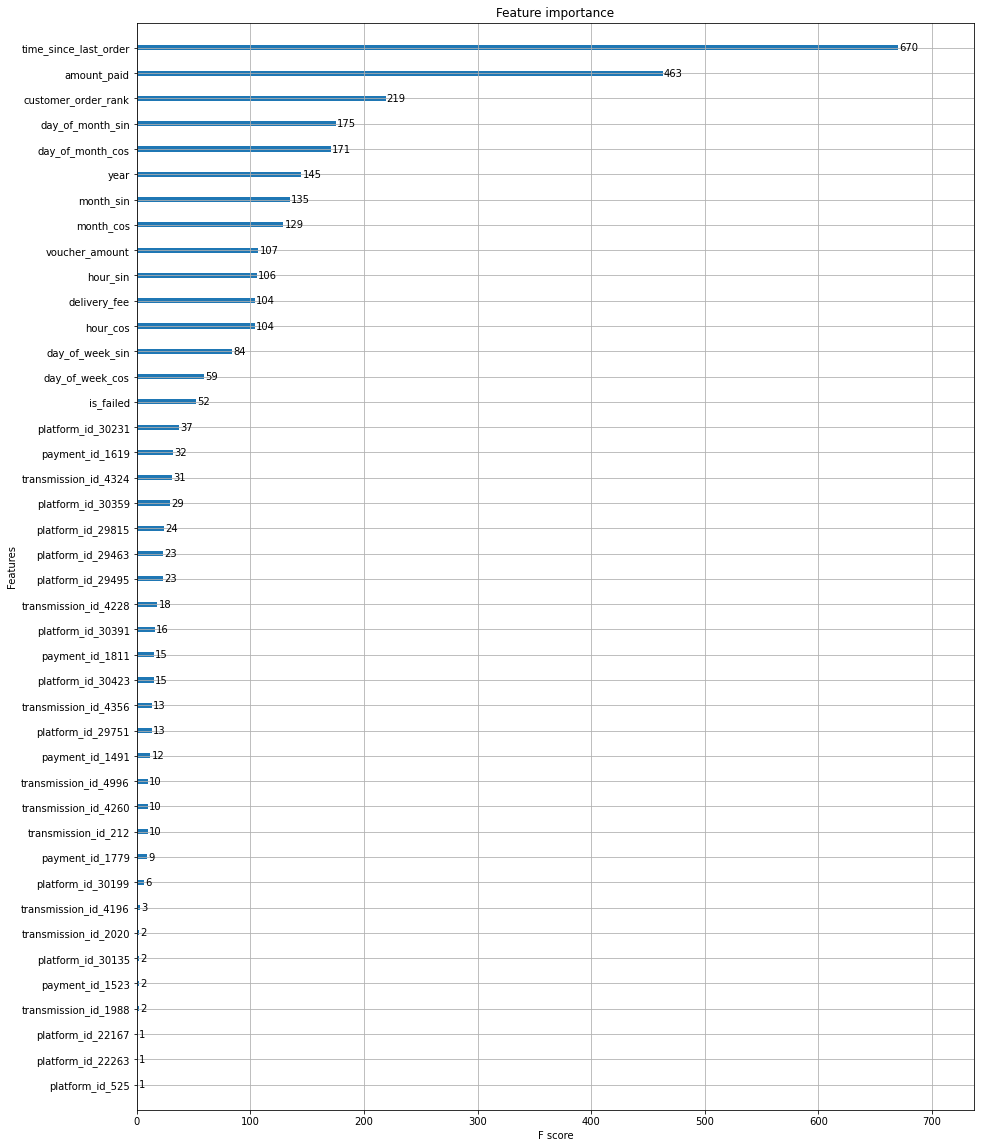

In [28]:
plt.rcParams["figure.figsize"] = (15, 20)
plot_importance(model_r)

### Classification Score

AUC: 0.537


Text(0.5, 1.0, 'ROC Curve')

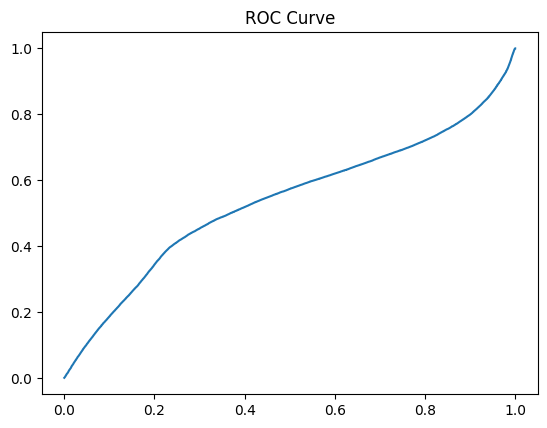

In [37]:
y_pred_proba = model_c.predict_proba(Testing_Data[Feature_Columns])[:,1]


plt.rcParams = plt.rcParamsDefault
# ROC and AUC score
fpr, tpr, thresholds = roc_curve(Testing_Data['is_returning_customer'], y_pred)
auc = roc_auc_score(Testing_Data['is_returning_customer'], y_pred)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")

In [39]:
y_pred = model_c.predict(Testing_Data[Feature_Columns])
# Confusion Matrix and Classification report
print(confusion_matrix(Testing_Data['is_returning_customer'], y_pred))
print(classification_report(Testing_Data['is_returning_customer'], y_pred))

[[143915  46033]
 [ 33053  22452]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.78    189948
           1       0.33      0.40      0.36     55505

    accuracy                           0.68    245453
   macro avg       0.57      0.58      0.57    245453
weighted avg       0.70      0.68      0.69    245453

